In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlptown-bert-30k/balanced30k.csv


In [4]:
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

2025-09-02 10:57:35.221910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756810655.402840      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756810655.455101      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
df = pd.read_csv('/kaggle/input/nlptown-bert-30k/balanced30k.csv')
df.head()

,Title,review/score,review/text,categories,word_count,label
0,The Good Earth,2.0,The book The Good Earth is about the rise and ...,Juvenile Fiction,262,0
1,Like Water for Chocolate,4.0,"Don't know why this book sticks in my mind, bu...",Fiction,55,2
2,Shadowy Horses,4.0,By far the best of the latest crop of Romantic...,Fiction,247,2
3,"The Hobbitt, or there and back again; illustra...",5.0,"Classic tale, great illustrations. A known qua...",Fiction,23,2
4,Shamanspace,1.0,"For the past year, I had come across Steve Ayl...",Fiction,226,0


In [6]:
# Preprocessing with basic text cleanup 
import re
def clean_for_bert(text):
    text = str(text)
    text = re.sub(r'\s+', ' ', text)             # normalize spaces
    return text.strip()

In [7]:
df['cleaned_text'] = df['review/text'].apply(clean_for_bert)
df.head()

,Title,review/score,review/text,categories,word_count,label,cleaned_text
0,The Good Earth,2.0,The book The Good Earth is about the rise and ...,Juvenile Fiction,262,0,The book The Good Earth is about the rise and ...
1,Like Water for Chocolate,4.0,"Don't know why this book sticks in my mind, bu...",Fiction,55,2,"Don't know why this book sticks in my mind, bu..."
2,Shadowy Horses,4.0,By far the best of the latest crop of Romantic...,Fiction,247,2,By far the best of the latest crop of Romantic...
3,"The Hobbitt, or there and back again; illustra...",5.0,"Classic tale, great illustrations. A known qua...",Fiction,23,2,"Classic tale, great illustrations. A known qua..."
4,Shamanspace,1.0,"For the past year, I had come across Steve Ayl...",Fiction,226,0,"For the past year, I had come across Steve Ayl..."


In [8]:
df['label'].value_counts().sort_index()

label
0    10000
1    10000
2    10000
Name: count, dtype: int64

In [9]:
df.head()

,Title,review/score,review/text,categories,word_count,label,cleaned_text
0,The Good Earth,2.0,The book The Good Earth is about the rise and ...,Juvenile Fiction,262,0,The book The Good Earth is about the rise and ...
1,Like Water for Chocolate,4.0,"Don't know why this book sticks in my mind, bu...",Fiction,55,2,"Don't know why this book sticks in my mind, bu..."
2,Shadowy Horses,4.0,By far the best of the latest crop of Romantic...,Fiction,247,2,By far the best of the latest crop of Romantic...
3,"The Hobbitt, or there and back again; illustra...",5.0,"Classic tale, great illustrations. A known qua...",Fiction,23,2,"Classic tale, great illustrations. A known qua..."
4,Shamanspace,1.0,"For the past year, I had come across Steve Ayl...",Fiction,226,0,"For the past year, I had come across Steve Ayl..."


In [10]:
from sklearn.model_selection import train_test_split
# Split dataset
X = df['cleaned_text']
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp)

In [11]:
print(df['label'].unique())

[0 2 1]


In [12]:
# Convert to Hugging Face dataset format
from datasets import Dataset

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

In [13]:
# Tokenization
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/21000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [14]:
# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [15]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "nlptown/bert-base-multilingual-uncased-sentiment",
    num_labels=3,
    ignore_mismatched_sizes=True
)

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./bert_fiction_sentiment/2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_strategy="steps",         
    logging_steps=10,                 
    report_to="none",
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

In [17]:
# Define Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='macro', zero_division=0),
        'recall': recall_score(labels, preds, average='macro', zero_division=0),
        'f1': f1_score(labels, preds, average='macro', zero_division=0)
    }

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_35/293716929.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
# Train the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,1.016200
20,0.865000
30,0.789800
40,0.809400
50,0.741400
60,0.679100
70,0.654300
80,0.617700
90,0.655500
100,0.677000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1971, training_loss=0.5379511431532424, metrics={'train_runtime': 1717.9759, 'train_samples_per_second': 36.671, 'train_steps_per_second': 1.147, 'total_flos': 8288072658432000.0, 'train_loss': 0.5379511431532424, 'epoch': 3.0})

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [21]:
eval_results = trainer.evaluate(val_dataset)
print(eval_results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.6210250854492188, 'eval_accuracy': 0.7485, 'eval_precision': 0.7474057437537421, 'eval_recall': 0.7484999999999999, 'eval_f1': 0.747892114680348, 'eval_runtime': 49.875, 'eval_samples_per_second': 120.301, 'eval_steps_per_second': 1.885, 'epoch': 3.0}


In [22]:
predictions = trainer.predict(val_dataset)
logits = predictions.predictions
y_true = predictions.label_ids
y_pred = logits.argmax(axis=1)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79      2000
     Neutral       0.66      0.64      0.65      2000
    Positive       0.80      0.81      0.81      2000

    accuracy                           0.75      6000
   macro avg       0.75      0.75      0.75      6000
weighted avg       0.75      0.75      0.75      6000



In [25]:
from transformers.trainer_utils import get_last_checkpoint
import os
import json
import matplotlib.pyplot as plt

log_file = "./bert_fiction_sentiment/2/checkpoint-1971/trainer_state.json"

with open(log_file) as f:
    data = json.load(f)

steps = []
losses = []

for log in data["log_history"]:
    if "loss" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

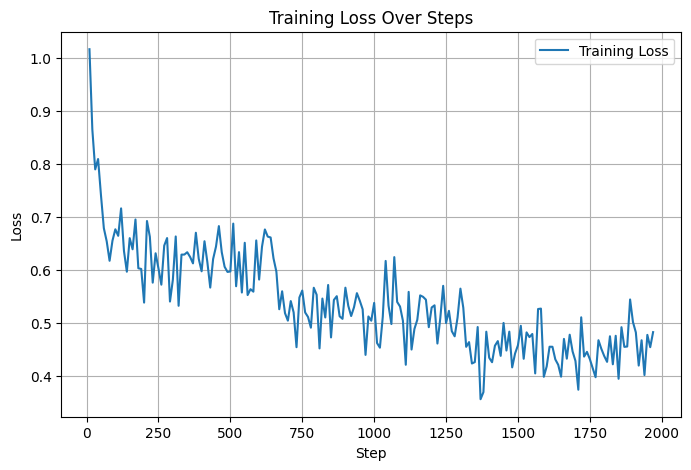

In [26]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.legend()
plt.show()

In [27]:
# Evaluate on test set
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)
print(classification_report(y_true, y_pred, zero_division=0))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1000
           1       0.67      0.65      0.66      1000
           2       0.80      0.83      0.82      1000

    accuracy                           0.75      3000
   macro avg       0.75      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000

